# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 17, 19, 20, and ML communication 

**Due date: April 12, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package for that in your cpsc330 conda environment. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the embeddings. 

**Your tasks:**

1. Calculate the cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

#### Question 1

In [6]:
similarities = {
    "word0": [],
    "word1": [],
    "similarity": []
}
for pair in word_pairs:
    similarities["word0"].append(pair[0])
    similarities["word1"].append(pair[1])
    similarities["similarity"].append(glove_wiki_vectors.similarity(pair[0], pair[1]))

pd.DataFrame(similarities).sort_values("similarity", ascending=False)

,word0,word1,similarity
4,dog,cat,0.879807
3,smart,intelligent,0.755273
0,coast,shore,0.700027
2,old,new,0.643249
1,clothes,closet,0.546276
5,tree,lawyer,0.076719


#### Question 2

The similarities make sense to an extent. 
- Dog and cat are both common domestic animals
- Smart and intelligent can be synonyms
- Coast and shore both refer to land near water
- old and new are antonyms
- clothes are stored in closets
- tree and lawyer are not similar at all, corresponding to the extremely low score

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using a dump of Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in the embeddings. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use embeddings in your models. 

In [7]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [8]:
glove_wiki_vectors.similarity("white", "rich")

0.4472359

In [9]:
glove_wiki_vectors.similarity("black", "rich")

0.51745194

In [10]:
analogy("man", "programmer", "woman")

man : programmer :: woman : ?


,Analogy word,Score
0,educator,0.585333
1,programmers,0.573053
2,linguist,0.543201
3,technician,0.537336
4,freelance,0.536212
5,animator,0.533937
6,translator,0.533419
7,software,0.496662
8,psychotherapist,0.495662
9,technologist,0.488051


In [11]:
analogy("men", "work", "women")

men : work :: women : ?


,Analogy word,Score
0,works,0.766605
1,working,0.760297
2,well,0.706947
3,done,0.702823
4,study,0.694778
5,care,0.681411
6,writing,0.677440
7,social,0.676755
8,education,0.675622
9,worked,0.674624


In [12]:
analogy("woman", "housewife", "man")

woman : housewife :: man : ?


,Analogy word,Score
0,homemaker,0.618261
1,loner,0.581096
2,schoolteacher,0.579345
3,slacker,0.566048
4,dad,0.550712
5,thug,0.535593
6,shopkeeper,0.526345
7,workaholic,0.524418
8,mom,0.523698
9,old,0.518858


In [13]:
analogy("heterosexual", "good", "lgbt")

heterosexual : good :: lgbt : ?


,Analogy word,Score
0,best,0.673102
1,well,0.614877
2,for,0.608162
3,critical,0.602974
4,award,0.597305
5,important,0.594038
6,community,0.592838
7,pride,0.590586
8,attention,0.589083
9,great,0.588720


In [14]:
analogy("male", "vote", "female")

male : vote :: female : ?


,Analogy word,Score
0,election,0.846487
1,votes,0.835162
2,elections,0.822575
3,voting,0.789490
4,voters,0.787616
5,voted,0.783951
6,polls,0.777235
7,democrats,0.770872
8,parliamentary,0.752749
9,ballot,0.749028


#### ANSWERS

1. Using models in the real world can be harmful because users of applications that integrate racially or otherwise bias'd models could have severe implications on stereotypes that may be discriminatory and prejudiced. Additionally, the influence of bias'd models can spread extremely fast without users even realizing the implications of information they may be unconditionally accepting.

2. (exploration above)

3. I used various analogy queries to see if the model had similar biases to the ones identified in class, and additional biases. It seems that the GloVe Wikipedia embeddings do not exhibit the biases that the Google News embeddings had regarding gender stereotypes. Additionally, the GloVe Wikipedia embedding does not seem to exhibit sexual orientation biases either.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's not in the vocabulary (e.g., "cpsc330"). 

#### Answer

1. The Wikipedia embedding definitely doesn't contain all words in the english language because language is extremely complicated with many unusual such as compound words, words created in fiction, or words that arose from slang trends. Trying to get a word vector not in the vocabulary will cause the model to throw an error.

In [15]:
# glove_wiki_vectors.similar_by_key("Draconian", "Fantasy")

In [16]:
# glove_wiki_vectors.similarity("cpsc330", "fun")

<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train a logistic regression with bag-of-words features and show the classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you see convergence issues).  
3. Discuss your results. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 

In [17]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [18]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [19]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [20]:
import spacy

nlp = spacy.load("en_core_web_md")

#### Question 1 LogisticRegression with CountVectorizer

In [21]:
from sklearn.metrics import classification_report

In [22]:
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, multi_class="ovr")
)
pipe.named_steps["countvectorizer"].fit(X_train)
pipe.fit(X_train, y_train)


Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='ovr'))])

In [23]:
X_test_predicted = pd.DataFrame(X_test)
X_test_predicted['predictions'] = pipe.predict(X_test)
X_test_predicted['target'] = y_test
X_test_predicted.head()

,moment,predictions,target
hmid,,,
62789,"Yesterday, my boss decided to upgrade my workstation to a much better one.",achievement,achievement
81694,The day my daughter was born. She is such a blessing.,affection,affection
83106,MY BEST FRIEND MARRIAGE PARTY,bonding,bonding
112096,eat my favourite food idli,enjoy_the_moment,enjoy_the_moment
75708,I went on a date with a guy that I really liked.,affection,affection


In [24]:
print(classification_report(y_test, pipe.predict(X_test)))

                  precision    recall  f1-score   support

     achievement       0.79      0.88      0.83      1302
       affection       0.89      0.92      0.91      1423
         bonding       0.90      0.85      0.87       492
enjoy_the_moment       0.62      0.51      0.56       469
        exercise       0.91      0.54      0.68        74
         leisure       0.73      0.69      0.71       407
          nature       0.76      0.44      0.55        71

        accuracy                           0.82      4238
       macro avg       0.80      0.69      0.73      4238
    weighted avg       0.81      0.82      0.81      4238



In [25]:
pipe.named_steps["logisticregression"].coef_.shape

(7, 8060)

#### Question 2 Average Embedding

In [26]:
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])
X_train_embeddings.shape


(9887, 300)

In [27]:
lgr = LogisticRegression(max_iter=2000, multi_class="ovr")
lgr.fit(X_train_embeddings, y_train)

LogisticRegression(max_iter=2000, multi_class='ovr')

In [28]:
print(classification_report(y_test, lgr.predict(X_test_embeddings)))

                  precision    recall  f1-score   support

     achievement       0.81      0.85      0.83      1302
       affection       0.85      0.92      0.89      1423
         bonding       0.85      0.78      0.81       492
enjoy_the_moment       0.62      0.50      0.55       469
        exercise       0.76      0.68      0.71        74
         leisure       0.75      0.66      0.70       407
          nature       0.70      0.70      0.70        71

        accuracy                           0.81      4238
       macro avg       0.76      0.73      0.74      4238
    weighted avg       0.80      0.81      0.80      4238



In [29]:
lgr.coef_.shape

(7, 300)

#### Question 3 + 4

3. Both BoW and Average Embedding models have certain targets with better `precision`, `recall`, and `f1-score`, however, the `weighted avg` seems to slightly favor the BoW representation. The BoW model would be more interpretable as it represents text as the frequency of words that occur. This is more interpretable because each feature corresponds to words in the text. One could examine the coefficients of the LogisticRegression model (one set of coefficients for each model trained for each target class) and examine the corresponding word the coefficient represents. The average embedding model would be less interpretable due to these features being created from complex neural networks to capture more semantic meaning. It would be harder to visualize and interpret directly but can still be interpreted using strategies such as feature importance.

4. In this example, there doesn't seem to be any noticeable benefit from using transfer learning through average embedding. The performance is quite similar, in fact slightly worse, to the simpler BoW model.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [30]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [31]:
df.shape

(18249, 13)

In [32]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [33]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~5 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [34]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [35]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain in Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

**ANSWER:**

We have separate measurements for each `region` and `type`. We have `143` unique `Date` measurements so, for example in the `region=Boise`, there are `286` examples which corresponds to exactly $2\times 143$. This is because there is one set of measurements for each `type=conventional` or `type=organic` for each region.

In [36]:
print(train_df.shape)
print(train_df['Date'].unique().shape)
print(train_df['region'].unique().shape)

(15441, 13)
(143,)
(54,)


In [37]:
train_df.query('region == "Boise"').shape

(286, 13)

In [38]:
train_df.query('Date == "2015-12-27"')

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
0,2015-12-27,0.99,386100.49,292097.36,27350.92,297.90,66354.31,48605.95,17748.36,0.00,conventional,2015,Atlanta
0,2015-12-27,1.17,596819.40,40450.49,394104.02,17353.79,144911.10,142543.88,2367.22,0.00,conventional,2015,BaltimoreWashington
0,2015-12-27,0.97,62909.69,30482.25,2971.94,5894.40,23561.10,23520.19,5.69,35.22,conventional,2015,Boise
0,2015-12-27,1.13,450816.39,3886.27,346964.70,13952.56,86012.86,85913.60,99.26,0.00,conventional,2015,Boston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2015-12-27,1.54,1652.19,0.00,73.22,0.00,1578.97,1336.27,242.70,0.00,organic,2015,Syracuse
0,2015-12-27,1.63,2161.84,874.75,17.54,0.00,1269.55,1216.67,52.88,0.00,organic,2015,Tampa
0,2015-12-27,1.52,549787.59,89709.92,206198.62,5836.04,248043.01,142262.93,105780.08,0.00,organic,2015,TotalUS
0,2015-12-27,1.46,142710.36,29880.32,48416.71,38.63,64374.70,17464.54,46910.16,0.00,organic,2015,West


In [39]:
train_df.query('Date == "2015-12-27"').describe(include="all")

/var/folders/7z/3s70y8y14bg5pg8xh_qrpctr0000gn/T/ipykernel_75961/2061968787.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_df.query('Date == "2015-12-27"').describe(include="all")


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
count,108,108.000000,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,108.000000,108,108.0,108
unique,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,54
top,2015-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conventional,NaN,Albany
freq,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54,NaN,2
first,2015-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.298426,6.833982e+05,2.358952e+05,2.566579e+05,2.890027e+04,1.619448e+05,1.242920e+05,3.316659e+04,4486.229444,NaN,2015.0,NaN
std,NaN,0.347076,2.765265e+06,9.995388e+05,1.039316e+06,1.245359e+05,6.394896e+05,4.938706e+05,1.355372e+05,21097.544106,NaN,0.0,NaN
min,NaN,0.490000,7.490300e+02,0.000000e+00,5.850000e+00,0.000000e+00,8.097000e+01,1.285000e+01,0.000000e+00,0.000000,NaN,2015.0,NaN
25%,NaN,0.990000,7.024875e+03,8.272250e+02,2.197718e+03,0.000000e+00,1.822140e+03,1.118762e+03,8.962500e+01,0.000000,NaN,2015.0,NaN


In [40]:
print(train_df.query('Date == "2015-12-27" & type == "conventional"').shape)
print(train_df.query('Date == "2015-12-27" & type == "conventional"')['region'].unique().shape)

(54, 13)
(54,)


<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

**ANSWER:**

The measurements in this dataset are equally spaced. This can be determined by taking all the dates measurements were taken (unique `Date`) and ordering them. Then by comparing the difference between each measurement and the previous measurement, we obtain an interval between measurements which was consistently `7 days`. Because this interval was consistent, the measurements are equally spaced.

In [41]:
train_df["Date"].unique().shape

(143,)

In [42]:
pd.DataFrame(train_df["Date"].unique()).sort_values(by=0).diff()

,0
51,NaT
50,7 days
49,7 days
48,7 days
47,7 days
...,...
108,7 days
107,7 days
106,7 days
105,7 days


In [43]:
pd.DataFrame(train_df["Date"].unique()).sort_values(by=0).diff()[0].unique()

array([          'NaT', 604800000000000], dtype='timedelta64[ns]')

<br><br>

### 2.3
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

**ANSWER:**

The regions are overlapping, because they can be both cities or "regions". Cities such as `Atlanta` overlap with large regions such as `TotalUS`.

In [44]:
train_df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

<br><br><br><br>

## Preparation for models

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 19, with some improvements.

In [45]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [46]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [47]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [48]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse than this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

**ANSWER:**

By setting `y_true` as the forecasted `AveragePriceNextWeek` and `y_pred` as the same as this weeks price `AveragePrice`, we get the score
$$R^2 = 0.8286$$

In [49]:
from sklearn.metrics import r2_score

In [50]:
train_df[['AveragePrice', 'AveragePriceNextWeek']].query('AveragePrice == AveragePriceNextWeek')

,AveragePrice,AveragePriceNextWeek
4,0.99,0.99
105,1.55,1.55
137,1.61,1.61
178,1.79,1.79
181,1.93,1.93
...,...,...
18056,1.22,1.22
18108,1.58,1.58
18149,1.36,1.36
18197,1.11,1.11


In [51]:
dummy_train_r2 = r2_score(train_df['AveragePriceNextWeek'], train_df['AveragePrice'])
dummy_train_r2

0.8285800937261841

In [52]:
dummy_test_r2 = r2_score(test_df['AveragePriceNextWeek'], test_df['AveragePrice'])
dummy_test_r2

0.7631780188583048

In [53]:
results = {
    "model": ["dummy"],
    "test_score": [dummy_test_r2],
    "train_score": [dummy_train_r2]
}
pd.DataFrame(results)

,model,test_score,train_score
0,dummy,0.763178,0.82858


<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

#### EDA

In [54]:
train_df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,AveragePriceNextWeek
count,15441.000000,1.544100e+04,1.544100e+04,1.544100e+04,1.544100e+04,1.544100e+04,1.544100e+04,1.544100e+04,15441.000000,15441.000000,15441.000000
mean,1.397126,8.415280e+05,2.915050e+05,2.987060e+05,2.438154e+04,2.269345e+05,1.739725e+05,4.997246e+04,2989.486697,2015.909008,1.401113
std,0.409543,3.413913e+06,1.257911e+06,1.217028e+06,1.131981e+05,9.354825e+05,7.167709e+05,2.215717e+05,17374.897311,0.792499,0.411514
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000,0.440000
25%,1.080000,1.009291e+04,8.790700e+02,3.114340e+03,0.000000e+00,4.072320e+03,2.087380e+03,1.066700e+02,0.000000,2015.000000,1.090000
50%,1.360000,1.044206e+05,8.217170e+03,2.983921e+04,1.987000e+02,3.732293e+04,2.419380e+04,2.348730e+03,0.000000,2016.000000,1.360000
75%,1.660000,4.273913e+05,1.113626e+05,1.518530e+05,7.051080e+03,1.035380e+05,7.913568e+04,1.952399e+04,106.940000,2017.000000,1.660000
max,3.250000,6.103446e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.629830e+07,1.256716e+07,4.324231e+06,551693.650000,2017.000000,3.250000


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNext

In [56]:
train_df['year'].unique()

array([2015, 2016, 2017])

In [57]:
train_df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'AveragePriceNextWeek'],
      dtype='object')

#### Build Preprocessor

In [58]:

numeric_features = [
    'AveragePrice', 
    'Total Volume', 
    '4046', 
    '4225', 
    '4770',
    'Total Bags', 
    'Small Bags', 
    'Large Bags', 
    'XLarge Bags', 
]
categorical_features = [
    'type',
    'year',
    'region'
]
drop_features = ["Date"]
target = ['AveragePriceNextWeek']

In [59]:
# FROM: Time Series Lecture CPSC 330
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        StandardScaler()
    )
    categorical_transformer = make_pipeline(
        OneHotEncoder(handle_unknown="ignore", sparse=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df[target]
    y_test = test_df[target]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [60]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [61]:
print(X_train_enc.shape)
print(train_df.shape)
print(y_train.shape)
print(X_test_enc.shape)
print(test_df.shape)
print(y_test.shape)

(15441, 68)
(15441, 14)
(15441, 1)
(2700, 68)
(2700, 14)
(2700, 1)


#### Train Ridge Model using given columns

In [62]:
from sklearn.linear_model import Ridge

In [63]:
# Ridge model
# train lr model on train set
# report train + test score
# return learned coefficient as df
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc, results, model_name):
    ridge_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
    ridge_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(ridge_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(ridge_pipe.score(test_df, y_test)))
    results['model'].append(model_name)
    results['train_score'].append(ridge_pipe.score(train_df, y_train))
    results['test_score'].append(ridge_pipe.score(test_df, y_test))
    ridge_coef = pd.DataFrame(
        data=ridge_pipe.named_steps["ridge"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return ridge_coef.sort_values(by="Coef", ascending=False)

In [64]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc, results, "ridge default columns")

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.325180
region_SanFrancisco,0.091341
region_HartfordSpringfield,0.088819
region_NewYork,0.070054
type_organic,0.051681
...,...
region_Denver,-0.047878
type_conventional,-0.051681
region_SouthCentral,-0.067115
region_DallasFtWorth,-0.068354


Ridge using just the given columns without any feature engineering has a slightly better score than the dummy model.

Lets try cross-validation with `TimeSeriesSplit`

#### Cross Validation with Time Series Split

In [65]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [66]:
train_df_ordered = train_df.sort_values(by=["Date"])
y_train_ordered = train_df_ordered["AveragePriceNextWeek"]
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
cross_val_score(lr_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8034591020878104

our validation score is worse than dummy

#### Feature Engineering

OHE Month as a feature -> basically no change in scores

In [67]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))
train_df[["Date", "Month"]].sort_values(by="Month")

,Date,Month
1304,2017-04-30,April
9869,2016-04-17,April
9025,2016-04-24,April
3332,2017-04-30,April
3331,2017-04-23,April
...,...,...
11241,2016-09-04,September
11242,2016-09-11,September
11243,2016-09-18,September
11293,2017-09-03,September


In [68]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc, results, "ridge with Months")

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.311424
region_SanFrancisco,0.106214
region_HartfordSpringfield,0.103903
region_NewYork,0.081879
region_Philadelphia,0.060428
...,...
region_Denver,-0.055380
type_conventional,-0.060229
region_SouthCentral,-0.077472
region_DallasFtWorth,-0.079459


OHE Season as a feature -> very little effect, in fact testing score decreases

In [69]:
# FROM Time series lecture cpsc330
def get_season(month):
    # remember this is Australia
    SUMMER_MONTHS = ["June", "July", "August"] 
    SPRING_MONTHS = ["March", "April", "May"]
    WINTER_MONTHS = ["December", "January", "February"]
    AUTUMN_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Spring"

In [70]:
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

In [71]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Season"], 
    drop_features + ["Month"],
    target
)
coeff_df = score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc, results, "ridge with Season")
coeff_df.loc[["Season_Spring", "Season_Summer", "Season_Winter", "Season_Autumn"]]

Train score: 0.85
Test score: 0.79


,Coef
Season_Spring,-0.009589
Season_Summer,0.019675
Season_Winter,-0.033566
Season_Autumn,0.023480


#### Feature Engineering Lag Features

In [72]:
df_hastarget_modified = create_lag_feature(
    df_hastarget, "AveragePrice", -1, ["region", "type"], "AveragePriceLastWeek", clip=True
)
train_df = df_hastarget_modified[df_hastarget_modified["Date"] <= split_date]
test_df = df_hastarget_modified[df_hastarget_modified["Date"] > split_date]
train_df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,AveragePriceLastWeek
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,1.22
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,1.24
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,1.17
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,1.06
5,2015-02-08,0.99,51253.97,1357.37,39111.81,163.25,10621.54,10113.10,508.44,0.0,conventional,2015,Albany,1.06,0.99


In [73]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features + ["AveragePriceLastWeek"], 
    categorical_features, 
    drop_features,
    target
)
coeff_df = score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc, results, "ridge with lag")


Train score: 0.85
Test score: 0.80


No change in scores, lets try adding in all the features we engineered (Month, Season, AveragePriceLastWeek)

In [74]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))

train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features + ["AveragePriceLastWeek"], 
    categorical_features+ ["Season", "Month"], 
    drop_features,
    target
)
coeff_df = score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc, results, "ridge with lag, Month, Season")


Train score: 0.86
Test score: 0.81


Only a slight increase in both training and testing scores

#### Try some other models

In [75]:
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [76]:
def score_model(preprocessor, train_df, y_train, test_df, y_test, model, results, model_name):
    ridge_pipe = make_pipeline(preprocessor, model)
    ridge_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(ridge_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(ridge_pipe.score(test_df, y_test)))
    results['model'].append(model_name)
    results['train_score'].append(ridge_pipe.score(train_df, y_train))
    results['test_score'].append(ridge_pipe.score(test_df, y_test))

In [77]:
svr = svm.SVR(kernel='rbf')
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

In [78]:
score_model(preprocessor, train_df, y_train, test_df, y_test, svr, results, "svr")

/Users/kennyjhcheng/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train score: 0.89
Test score: 0.80


In [79]:
score_model(preprocessor, train_df, y_train, test_df, y_test, dt, results, "DecisionTreeRegressor")

Train score: 1.00
Test score: 0.55


In [80]:
score_model(preprocessor, train_df, y_train, test_df, y_test, rf, results, "RandomForestRegressor")

/Users/kennyjhcheng/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Train score: 0.98
Test score: 0.78


#### Hyperparameter Optimization for Ridge

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
param_grid = {
    "ridge__alpha": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
}
ridge_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
grid_search = GridSearchCV(ridge_pipe, param_grid, cv=5)
grid_search.fit(train_df, y_train)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results[['rank_test_score', 'param_ridge__alpha', 'mean_test_score', 'std_test_score']].sort_values(by="rank_test_score")

,rank_test_score,param_ridge__alpha,mean_test_score,std_test_score
5,1,100,0.847713,0.016645
4,2,10,0.844843,0.017274
3,3,1.0,0.844026,0.017596
2,4,0.1,0.843931,0.017636
1,5,0.01,0.843922,0.017640
0,6,0.001,0.843921,0.017641
6,7,1000,0.840003,0.021125


In [83]:
print("Train score: {:.2f}".format(grid_search.score(train_df, y_train)))
print("Test score: {:.2f}".format(grid_search.score(test_df, y_test)))
results['model'].append("ridge with alpha=100, lag + feature engineering")
results['train_score'].append(grid_search.score(train_df, y_train))
results['test_score'].append(grid_search.score(test_df, y_test))

Train score: 0.86
Test score: 0.81


#### Conclusion

After experimenting with

1. Ridge model with default columns
2. Ridge model feature engineered `Month` columns
3. Ridge model feature engineered `Season` columns
4. Ridge model with lag features for `AveragePriceLastWeek`
5. Ridge model with lag features and feature engineered features
6. Other models such as `SVR`, `DecisionTreeRegressor`, and `RandomForestRegressor`
7. Ridge model with lag + feature engineered features + hyperparameter optimization

The best model out of the ones trained are the ridge models that used all of feature engineered and lag features, and additionally the one with feature engineering.

However, they were only better by a small margin of ~0.01 compared to the other models which may not be significant to generalize them as "better".

In [84]:
pd.DataFrame(results).sort_values(by="test_score")

,model,test_score,train_score
7,DecisionTreeRegressor,0.550175,1.000000
0,dummy,0.763178,0.828580
8,RandomForestRegressor,0.784717,0.979779
3,ridge with Season,0.793717,0.848674
6,svr,0.795096,0.888726
1,ridge default columns,0.795302,0.845982
4,ridge with lag,0.801458,0.853079
2,ridge with Months,0.801826,0.850409
9,"ridge with alpha=100, lag + feature engineering",0.809163,0.856684
5,"ridge with lag, Month, Season",0.809198,0.857239


<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

**ANSWER:**

1. One example of time series data that likely has unequally spaced time points is `medical records`. Time stamped data such as appointments, medical tests, prescriptions, etc. do not necessarily occur at a fixed interval. It could be useful to analyze this data to predict treatment progression.
2. Creating lagged versions of features would struggle with unequally spaced time points because the shift between each record/example would be uneven. It would be difficult to, for example, "Forecast the next week", if we simply create lag features based on the previous row, since unequally spaced data could be spaced any interval apart. The lag feature would then no longer represent what happens in a consistent forecasted interval.

    Feature engineering to encode the date as more features would not suffer as much from unequally spaced times especially if you split the date into features such as seasons, months, days of the week that would not rely on the spacing between examples

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

**ANSWER:**

1. This method suffers from *right-censoring* in which the method is biased towards the window of data collection. Treating customer churn as a binary classification of whether they "churned" does not account for customers who have not yet churned and are/will still be subscribed for some time. 

    Additionally, this prediction is not very useful because it only predict whether customers will churn in the time window of data collection, it would be more useful to predict the time till customers churn to understand how to retain customers.

2. As we don't know what the survival function looks like, we don't have enough information to answer. However, if we assume that the survival function is likely a decreasing function, then customer B who has been with the service for a year is probabilistically more likely to leave the service first. Since customer A just joined, the probability the customer will survive is greater than customer B.

3. If a customer's survival function is flat during a certain period, it indicates that the probability the customer survives during that period is unchanging and the risks associated with the customer not surviving are independent of time.

    However, this does not mean that the customer will survive definitely, only the probabilbity that they will survive is constant during the period.

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### Exercise 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side machine learning related project in a "blog post" or report format. **You can write the post in Markdown in the notebook**, no need to write a real blog post (though you can if you want too!).

The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

# Avocadabra! What's the price of Avocados next week

I remember my dad telling me when he first immigrated to Canada, avocados were quite a cheap fruit that he didn't find taste very good. These days, avocados can be quite expensive selling for $2-3 CAD each at the grocery store when not on sale. It has started trending as a healthy fruit with many benefits such as the abundance of healthy fats.

### Problem

The biggest problem in my personal life is how expensive the avocados are. Coincidentally, in my applied machine learning course, I had the opportunity to explore and build a model to **forecast the price of avocados**.

### Components of the Project

My work was divided into 

1. Exploratory Data Analysis (EDA)
2. Feature engineering
3. Preprocessing
4. Testing models
5. Results
6. Limitations

#### EDA

The dataset I will be using to train and test my model is the [Avocado Prices Dataset](https://www.kaggle.com/datasets/neuromusic/avocado-prices) from Kaggle.

This dataset organizes avocado prices by the `region`, which can be a city or a region, and `type`, either `organic` or `conventional`. Every combination of `region` and `price` has an equal set of measurements for each of the weeks measured, seen in the visualization below.

Additionaly, the regions are overlapping, including smaller areas such as cities like `Atlanta` and larger regions like `TotalUS`.


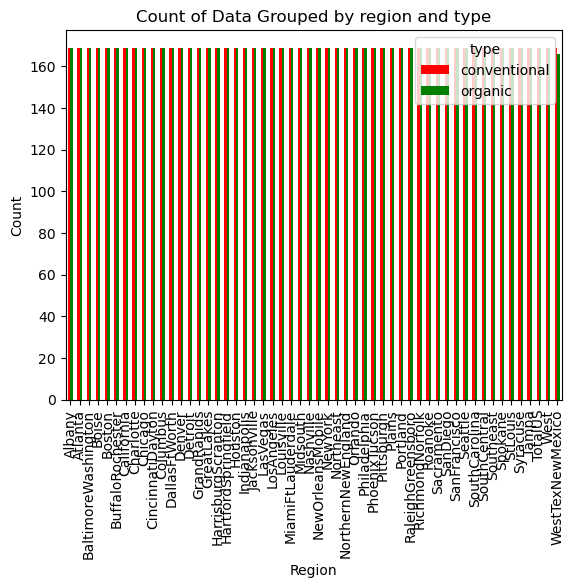

In [85]:
counts = df.groupby(['region', 'type']).size().unstack()

# Plot the counts as a bar chart with colored bars
counts.plot(kind='bar', color=['red', 'green'])

# Set the x-axis label and title
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Count of Data Grouped by region and type')
plt.xticks(rotation=90);

This dataset has measurements from `2015-01-04` to `2018-03-25`, approximately 3.25 years of data. With each measurement spaced exactly 1 year apart. The consistent interval of measurements will make forecasting easier which I'll go more into in feature engineering.

Because the data is a time series, I will split it so that there's around 6 months of testing data to evaluate models and 2.75 years of training data to train our models as seen below visualizing the split for one region-type combination.

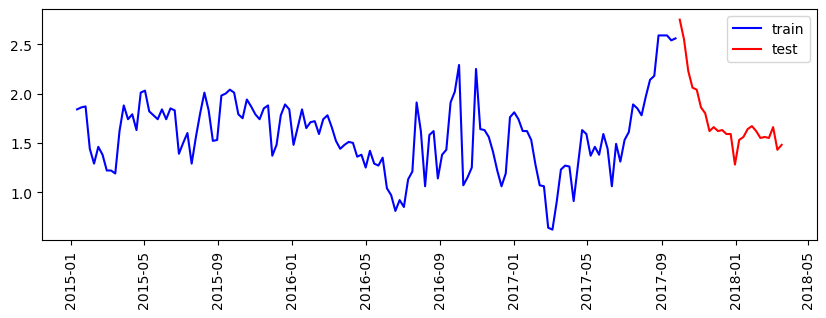

In [86]:
plt.figure(figsize=(10, 3))
train_df_viz = train_df.query('region == "Atlanta" & type == "organic"')[['Date', 'AveragePrice']].set_index('Date').sort_index()
test_df_viz = test_df.query('region == "Atlanta" & type == "organic"')[['Date', 'AveragePrice']].set_index('Date').sort_index()
plt.plot(train_df_viz, "b", label="train")
plt.plot(test_df_viz, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

I will be ignoring the the complicated division of data with overlapping regions, and a series of measurements for each `region`, `type` combination and simply using the dataset with some feature engineering and preprocessing.

#### Feature Engineering

An important part of this project was recognizing that the data is ordered by `Date`, the time of the measurements of avocado price. Because we are trying to predict the future avocado price, the time order and features we can extract from it could be important predictors of future avocado prices.

The first thing we engineered was actually the `target`, the true value of what we want to predict. Our goal is to predict the avocado next week which is actually already encoded into our data. Because each measurement is chronologically separated by a week, the real price of avocados next week can be obtained by creating a new column and setting the avocado `AveragePriceNextWeek` to be the next row's value, ordered by `Date`, and grouped by `region` and `type`. This `target` will be used to evaluate whether our model correctly predicts the next value.

Additionally, some feature columns created using the time series data that takes the form `yyyy-mm-dd` are:
- `Month` -> taken from the time series data, this feature isolates the Month as a feature and predictor of avocado prices
- `Season` -> by groupings months into 3-month seasons as a predictor
- `AveragePriceLastWeek` -> using the price of the previous week as a predictor to account for past prices

#### Preprocessing

Before using our data, I needed to transform it so that categorical features are interpretable by the models we will use and numeric values will all have the same scale, so that their impact is based on the patterns identified within them rather than their magnitude.

Features that are 
- numeric include: `AveragePrice`, `Total Volume`, `4046`, `4225`, `477`',`Total Bags`, `Small Bags`, `Large Bags`, `XLarge Bags`, `AveragePriceLastWeek`
- categorical: `type`, `year`, `region`, `Season`, `Month`

By using `StandardScaler` to normalize numeric features and `OneHotEncoder` to encode categorical features, I defined a preprocessor to be used prior to modelling.

#### Testing Models



As a baseline, to check that models perform better than a "simple" way to forecast avocdo prices, I evaluated a dummy model using a basic pattern that avocado prices next week will be the same as the current week.

I primarily used `Ridge`, a common regression model in `sklearn` which produces interpretable coefficients for each of the features to analyze which features are significant to the avocado price forecast. I tested a combination of the features previously engineered to see which ones have an impact on our predictions. 

Finally, I created a model in which I optimized the hyperparameter of `Ridge`, `alpha` for the best combination of engineered features. `alpha` is a hyperparameter that influences the regularization, and therefore complexity of patterns identified by `Ridge`. This hyperparameter should be optimized because we don't want our model identifying patterns that are too complex (overfitting) which don't reflect real patterns and missing patterns (underfitting) which means we miss important patterns for prediction.

 Additionally, I also tried some other regression models such as `DecisionTreeRegressor`, a non-linear regression model based on decision trees, `RandomForestRegressor` and ensemble model utilizing a number of decision trees, and Support Vector Regression (`SVR`) which uses a non-linear kernel used to fit the model.

For each model, I recorded the training score (blue in the plot) and test score (red in the plot). The training score is obtained by evaluating the models on the data used to train it and the testing score evaluates the model on new "unseen" data.

My results will be analyzed using the best of these models, `Ridge` that was optimized and using engineered features.

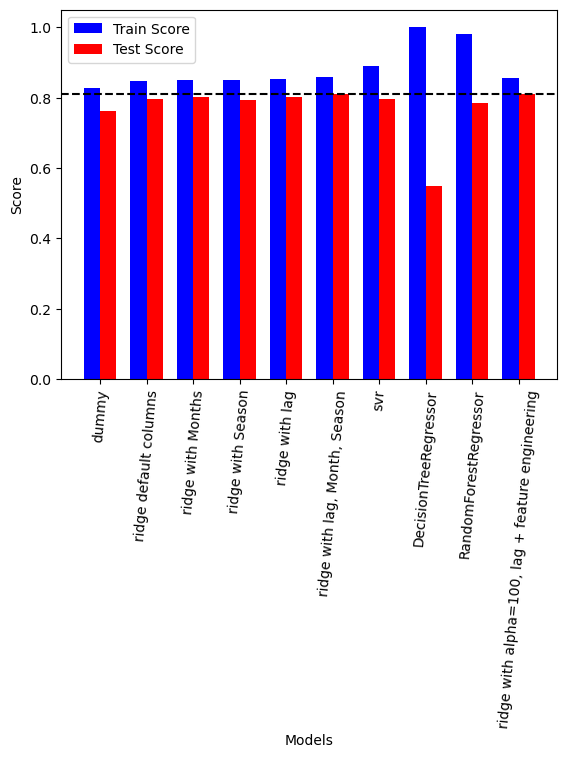

In [87]:
models = results['model']
train_scores = np.array(results['train_score'])
test_scores = np.array(results['test_score'])
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, train_scores, width, color='b', label='Train Score')
ax.bar(x + width/2, test_scores, width, color='r', label='Test Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
plt.xticks(rotation=85)
plt.xlabel('Models')
plt.ylabel('Score')
ax.axhline(y=0.81, color='k', linestyle='--')
ax.legend()


#### Results

Althought the performance of the `Ridge` models did not differ much from each other, and only improved from the dummy model by approximately `0.05`, we can see from the plots of the training and testing prediction price versus true price below that the model neither underfits nor overfits. The points over the line are over-predictions and under the lines are under-predictions. There seems to be quite an even amount of over and under-predictions until we reach the higher-prices in which there seems to be more under predictions.

Overall, the training and testing score have decent values, with a small gap between them. A testing and training score around 0.8 indicates that we are not underfitting and finding sufficient patterns to forecast avocado prices for the next week.

The small gap in testing and training score indicates that our model is not overfitting, since the training score and testing score are similar, the patterns learned in testing generalize decently to new examples.

We can also look at the coefficient values obtained by our `Ridge` model to see if they make sense. I've plotted the top 10 coefficients by magnitude, which are the 10 features with the biggest impact, positive or negaitvely on forecasting next week's avocado prices. It makes sense that the previous week and current week's price are good predictors for future prices as there seems to be a good linear relationship between previous and future prices. 

The other features such as regions, amount sold for types of avocados and sizes of bags, etc. all seem to be weaker predictors for forecasting.

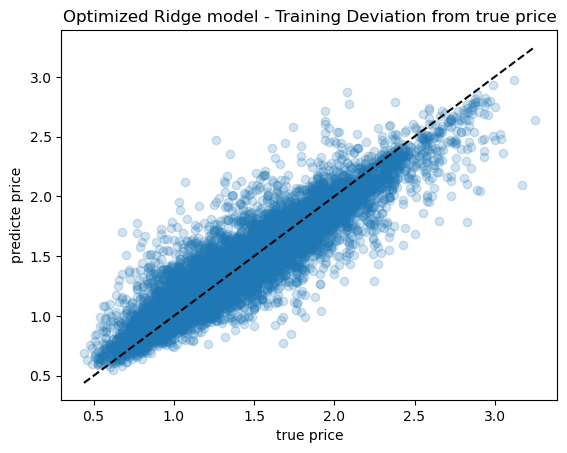

In [88]:
plt.scatter(y_train, grid_search.predict(train_df), alpha=0.2)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.title("Optimized Ridge model - Training Deviation from true price")
plt.xlabel("true price")
plt.ylabel("predicte price");

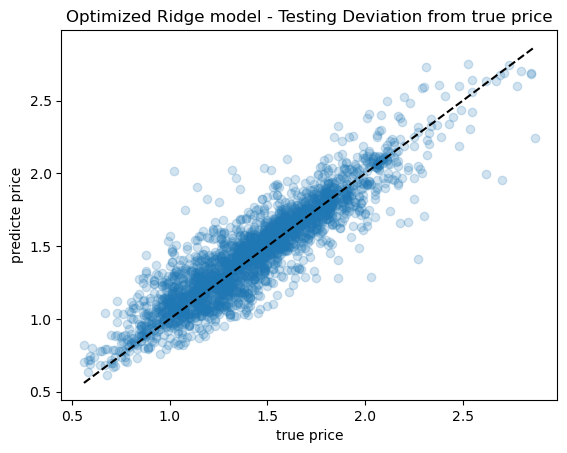

In [89]:
plt.scatter(y_test, grid_search.predict(test_df), alpha=0.2)
grid = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(grid, grid, "--k")
plt.title("Optimized Ridge model - Testing Deviation from true price")
plt.xlabel("true price")
plt.ylabel("predicte price");

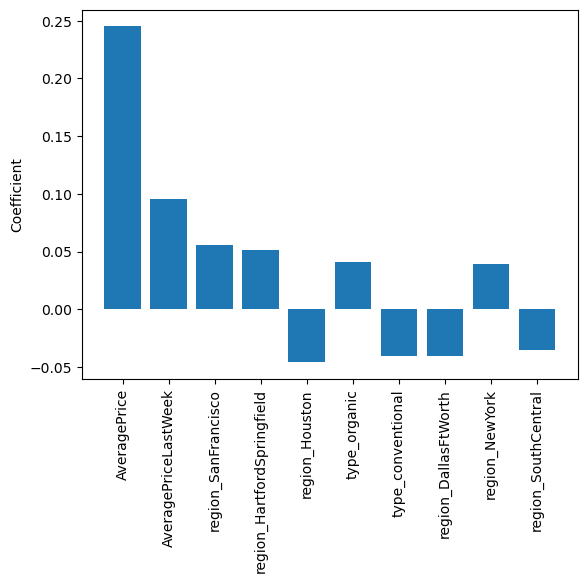

In [90]:
ridge_coef = pd.DataFrame(
        data=grid_search.best_estimator_.named_steps['ridge'].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
ridge_coef['Coef_abs'] = ridge_coef['Coef'].abs()
ridge_coef = ridge_coef.sort_values(by="Coef_abs", ascending=False)
coef = ridge_coef['Coef'][:10]
plt.bar(range(len(coef)), coef)
plt.xticks(range(len(coef)), ridge_coef.index[:10], rotation=90)
plt.ylabel('Coefficient')
plt.show()

#### Limitations
Some limitations that influenced my results were
1. Insufficient time: If I had more time, I would have tried more features other than common ones for feature engineering and varying combinations. Additionally, possibly by looking at their correlation, I could also use a better combination of features. With more time I would also be able to perform hyperparameter optimization on more models.
2. Insufficient computing power: With more computing power (and time), I could conduct hyperparameter optimization on not only `Ridge` but also the other models, including more complicated ensemble models which may be able to produce better scores.
3. Splitting of data: Due to external factors that the dataset not captures, it is possible that the testing the model on only 6 months of data ignores some of the features we engineered such as `Month` and `Season`, since our test data only occurs in half the months and seasons. Trying other train-test splits or using a larger dataset to do proper cross-validation would allow me to better verify these results.
4. Assumed Linearity: By primarily using `Ridge`, the model can be more interpretable, however it assumes linear patterns in the data. Without sufficiently diving into non-linear models and other linear models, these patterns may not be found. Additionally, ensembles could be a good method of capturing both linear and non-linear patterns in data.

#### Conclusion

When approaching a new dataset, there are many ways you can approach the problem. By pre-processing, trying different ways of feature engineering, and testing out various models, we can find one(s) that best identify generalizable patterns to accomplish prediction goals through supervised learning. 

It is important to recognize that although training a model may not take long, the steps in order to explore, optimize, and analyze a model that has good generalizability is extremely time consuming and requires many models to be trained in the process.

This project has been a fantastic way of applying many of the concepts learn through CPSC 330: Applied Machine Learning and has provided insight into the complexity but never-ending curiosity that exploring machine learning projects have.

<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

**ANSWER:**
One effective communication technique was the structural organization of the blog post. By using ordered and unordered lists separated by paragraph breaks and visualizations, the organization allows users to incrementally learn information from the blogpost necessary to understand and follow along with the blog post.

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

**ANSWER:**
My biggest takeaway into this course is that there are so many tradeoffs, optimizations, and decisions that must be considered when building machine learning models on top of ethics. Additionally, it is important to communicate the learnings from machine learning through statistics, visualizations, and analysis to bring meaning to the results. Exploring and applying these concepts in combination has been a fantastic introduction into the complexity of machine learning.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

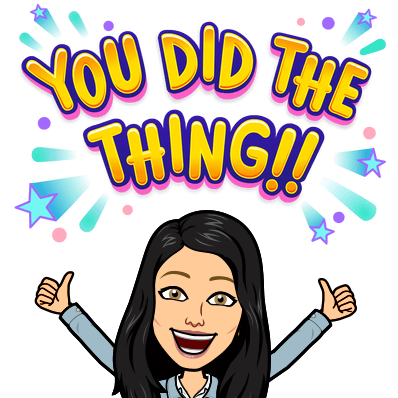

In [91]:
from IPython.display import Image

Image("eva-congrats.png")